In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import my_finance_functions as mff
import plotly.graph_objects as go
import datetime
import mplfinance as mpf

%load_ext autoreload
%autoreload 2
#%matplotlib inline

print("Librarias OK!")

Librarias OK!


In [2]:
GGAL = mff.import_data("GGAL.BA")
GGAL["2019":].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,104.000000,107.699997,101.050003,106.949997,105.577736,905540.0
2019-01-03,107.000000,108.099998,103.949997,107.900002,106.515549,830389.0
2019-01-04,108.400002,114.650002,108.400002,113.949997,112.487923,1896364.0
2019-01-07,114.000000,121.000000,113.750000,117.500000,115.992378,1835032.0
2019-01-08,118.000000,119.000000,113.000000,116.500000,115.005203,1077928.0


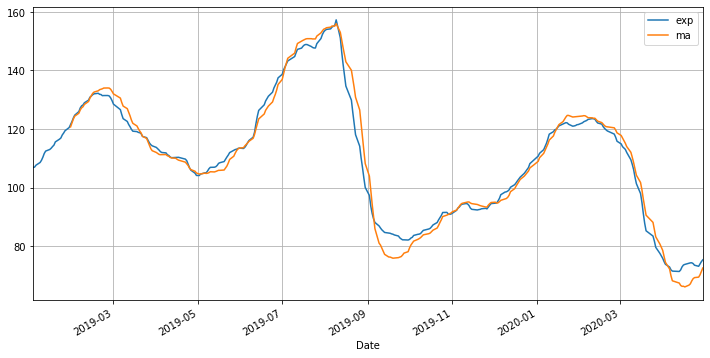

In [12]:
exp1 = GGAL["2019":]["Close"].ewm(span=20, adjust=False).mean()
ma1 = GGAL["2019":]["Close"].rolling(window=20).mean()

ax1 = exp1.plot(figsize = (12,6))
#GGAL["2019":]["Close"].plot()
ma1.plot()
ax1.legend(["exp","ma"])
ax1.grid()

In [3]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=GGAL["2019":].index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = GGAL["2019":]['Close'].rolling(window=short_window, min_periods = 1, center = False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = GGAL["2019":]['Close'].rolling(window=long_window, min_periods = 1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
signals.head()

,signal,short_mavg,long_mavg,positions
Date,,,,
2019-01-02,0.0,106.949997,106.949997,NaN
2019-01-03,0.0,107.424999,107.424999,0.0
2019-01-04,0.0,109.599999,109.599999,0.0
2019-01-07,0.0,111.574999,111.574999,0.0
2019-01-08,0.0,112.559999,112.559999,0.0


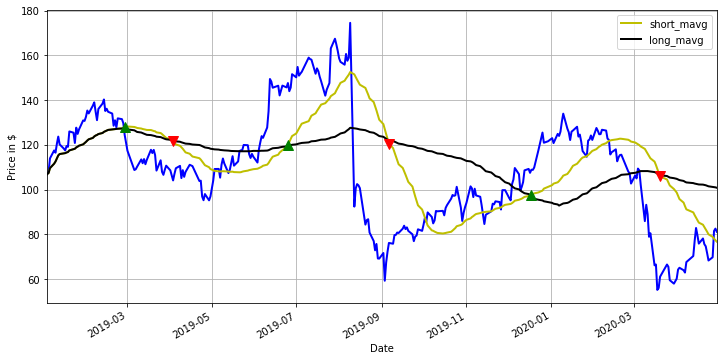

In [4]:
# Initialize the plot figure
fig = plt.figure(figsize = (12,6))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
GGAL["2019":]['Close'].plot(ax=ax1, color='b', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., color = ['y','k'])

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r')
    
ax1.grid()
# Show the plot
plt.show()

In [5]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['GGAL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(GGAL["2019":]['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(GGAL["2019":]['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(GGAL["2019":]['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
positions.head()

,GGAL
Date,
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-07,0.0
2019-01-08,0.0


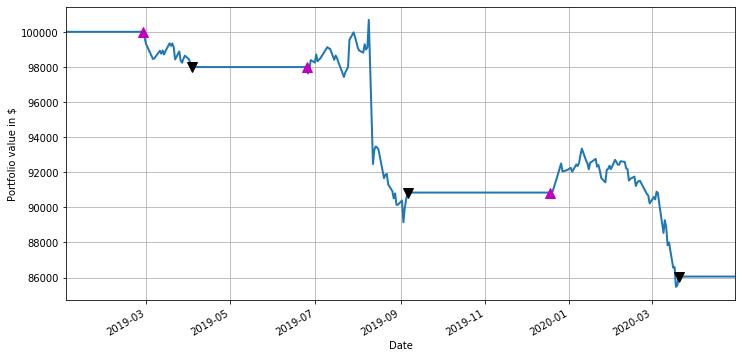

In [6]:
# Create a figure
fig = plt.figure(figsize = (12,6))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')
ax1.grid()
# Show the plot
plt.show()

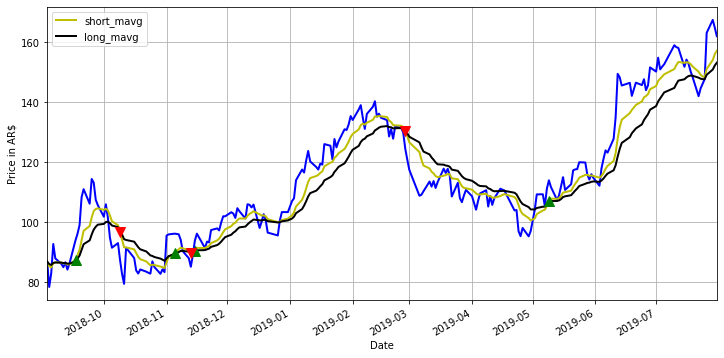

In [19]:
strategy = mff.mav_strategy(GGAL["2018-09":"2019-07"], 10, 20, exponential=True)
mff.plot_strategy(GGAL["2018-09":"2019-07"], strategy)

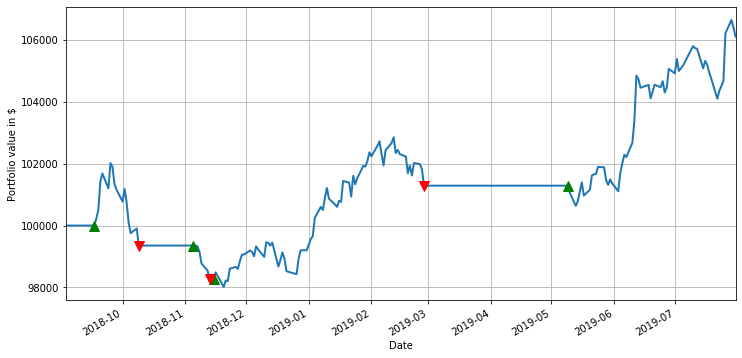

In [20]:
portf = mff.backtest(GGAL["2018-09":"2019-07"], strategy)
mff.plot_backtesting(portf, strategy)

In [21]:
portf.tail()

,Asset,holdings,cash,total,returns
Date,,,,,
2019-07-25,14764.9994,14764.9994,89898.2558,104663.2552,0.001483
2019-07-26,16314.9994,16314.9994,89898.2558,106213.2552,0.014809
2019-07-29,16744.9997,16744.9997,89898.2558,106643.2555,0.004048
2019-07-30,16489.9994,16489.9994,89898.2558,106388.2552,-0.002391
2019-07-31,16205.0003,16205.0003,89898.2558,106103.2561,-0.002679


In [34]:
def STOK(close, low, high, n, slow = 0): 
    #STOK = ((close - pd.rolling_min(low, n)) / (pd.rolling_max(high, n) - pd.rolling_min(low, n))) * 100
    STOK = ((close - low.rolling(n).min())/(high.rolling(n).max() - low.rolling(n).min()))*100
    if slow != 0:
        STOK = STOK.rolling(window=slow).mean()
    return STOK

def STOD(STOK):
    STOD = STOK.rolling(window = 3).mean()
    return STOD

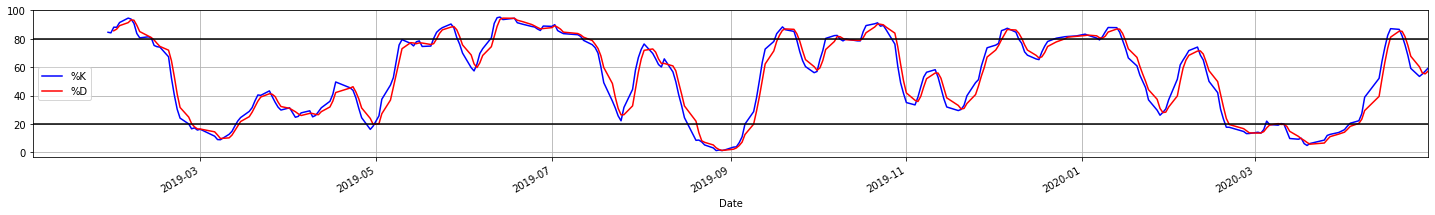

In [41]:
K = STOK(GGAL["2019":]['Close'], GGAL["2019":]['Low'], GGAL["2019":]['High'], 14, 6)
D = STOD(K)

#GGAL["2018-09":"2019-07"]["Close"].plot(figsize = (12,6))
K.plot(figsize = (25,3), color = 'b')
D.plot(color = 'r')
plt.axhline(80, color = 'k')
plt.axhline(20, color = 'k')
plt.grid()
plt.legend(['%K','%D'])